### Applico un algoritmo di rete neurale densa (Dense Neural Network) a un dataset di classificazione

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

sns.set_theme()

random_state = 42

In [ ]:
df=pd.read_csv('/content/dataset_titanic.csv')
df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
def preprocess_titanic_dataset(df_train, df_test):
    df_train = df_train.copy(deep=True)
    df_test = df_test.copy(deep=True)

    df_X_train_preprocessed = pd.DataFrame(index=df_train.index)
    df_X_test_preprocessed = pd.DataFrame(index=df_test.index)

    series_y_train = pd.Series(index=df_train.index, data=df_train['Survived'])
    series_y_test = pd.Series(index=df_test.index, data=df_test['Survived'])

    # Fill nan values for column 'Embarked'
    embarked_mode = df_train['Embarked'].mode()[0]
    df_train['Embarked'] = df_train['Embarked'].fillna(embarked_mode)
    df_test['Embarked'] = df_test['Embarked'].fillna(embarked_mode)

    # Fill nan values for column 'Age'
    age_median = df_train['Age'].median()
    df_train['Age'] = df_train['Age'].fillna(age_median)
    df_test['Age'] = df_test['Age'].fillna(age_median)

    # Standardization for numerical features
    features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
    ss = StandardScaler()
    X_train_std = ss.fit_transform(df_train[features])
    X_test_std = ss.transform(df_test[features])
    df_X_train_preprocessed[features] = X_train_std
    df_X_test_preprocessed[features] = X_test_std

    # One-hot-encoding for categorical features
    features = ['Sex', 'Embarked']
    ohe = OneHotEncoder(drop='first', sparse_output=False,handle_unknown='ignore')
    X_train_ohe = ohe.fit_transform(df_train[features])
    X_test_ohe = ohe.transform(df_test[features])
    features_names_out = ohe.get_feature_names_out()
    df_X_train_preprocessed[features_names_out] = X_train_ohe
    df_X_test_preprocessed[features_names_out] = X_test_ohe

    return df_X_train_preprocessed, df_X_test_preprocessed, series_y_train, series_y_test


def evaluate_model(model, X_train, y_train, X_test, y_test, show_confusion_matrix=False):
  train_probs = model.predict(X_train).ravel()
  test_probs = model.predict(X_test).ravel()

  y_train_pred = (train_probs > 0.5).astype(int)
  y_test_pred = (test_probs > 0.5).astype(int)

  acc_train = accuracy_score(y_train, y_train_pred)
  acc_test = accuracy_score(y_test, y_test_pred)

  print(f"accuracy train: {acc_train:.3f}")
  print(f"accuracy test: {acc_test:.3f}")

  cf_matrix_test = confusion_matrix(y_test, y_test_pred)

  if show_confusion_matrix:
    ax = sns.heatmap(cf_matrix_test, annot=True, fmt='d')
    ax.set_title('Confusion matrix on test set')
    ax.set_xlabel('Predicted values')
    ax.set_ylabel('True values')
    plt.show()

  return acc_train, acc_test, cf_matrix_test

In [ ]:
df_train, df_test = train_test_split(df, test_size=.2, random_state=random_state)

df_X_train_preprocessed, df_X_test_preprocessed, series_y_train, series_y_test = preprocess_titanic_dataset(df_train, df_test)

X_train = df_X_train_preprocessed.values

X_test = df_X_test_preprocessed.values

y_train = series_y_train.values

y_test = series_y_test.values

In [ ]:
# Initialize the model
model = keras.Sequential()

# Add a Dense (fully connected) layer with 64 units(neurons) and ReLU activation
model.add(layers.Dense(64, activation='relu', input_shape=(df_X_train_preprocessed.shape[1],)))

# Add another layer
model.add(layers.Dense(64, activation='relu'))

# Add a final output layer with 1 unit for binary classification
model.add(layers.Dense(1, activation='sigmoid'))

# Display the model summary
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,801 (18.75 KB)

 Trainable params: 4,801 (18.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model by specifying the optimizer, loss function, and metrics to
# track
model.compile(
    optimizer='adam',               # Adam optimizer for adaptive learning rate adjustments
    loss='binary_crossentropy',
    metrics=['accuracy']            # Metric to track: accuracy of predictions
)

In [ ]:
n_epochs = 25

# Train the model on the training data with specified parameters
history = model.fit(
    X_train,                # Training input data
    y_train,                # Training labels (target values)
    epochs=n_epochs,               # Number of times the entire dataset will be iterated over
    batch_size=64,          # Number of samples per gradient update
    validation_split=0.2    # Fraction of training data (20%) to use as validation data
)

Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.4290 - loss: 0.7166 - val_accuracy: 0.7203 - val_loss: 0.6613
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7456 - loss: 0.6493 - val_accuracy: 0.7552 - val_loss: 0.6080
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7180 - loss: 0.6019 - val_accuracy: 0.7552 - val_loss: 0.5657
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7209 - loss: 0.5737 - val_accuracy: 0.7552 - val_loss: 0.5304
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7674 - loss: 0.5346 - val_accuracy: 0.7552 - val_loss: 0.5021
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7707 - loss: 0.5063 - val_accuracy: 0.7692 - val_loss: 0.4809
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7919 - loss: 0.4904 - val_accuracy: 0.7762 - val_loss: 0.4637
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7888 - loss: 0.4809 - val_accuracy: 0.7902 - val_loss: 0.4479


In [ ]:
df_training_history = pd.DataFrame(history.history, index=range(1, n_epochs+1))

df_training_history.index.name = 'epoch'

df_training_history

,accuracy,loss,val_accuracy,val_loss
epoch,,,,
1,0.504394,0.703158,0.720280,0.661344
2,0.739895,0.639745,0.755245,0.608015
3,0.722320,0.597779,0.755245,0.565714
4,0.725835,0.561523,0.755245,0.530409
5,0.755712,0.531800,0.755245,0.502068
6,0.757469,0.508397,0.769231,0.480931
7,0.783831,0.489144,0.776224,0.463713
8,0.804921,0.472602,0.790210,0.447862
9,0.808436,0.457063,0.797203,0.431624


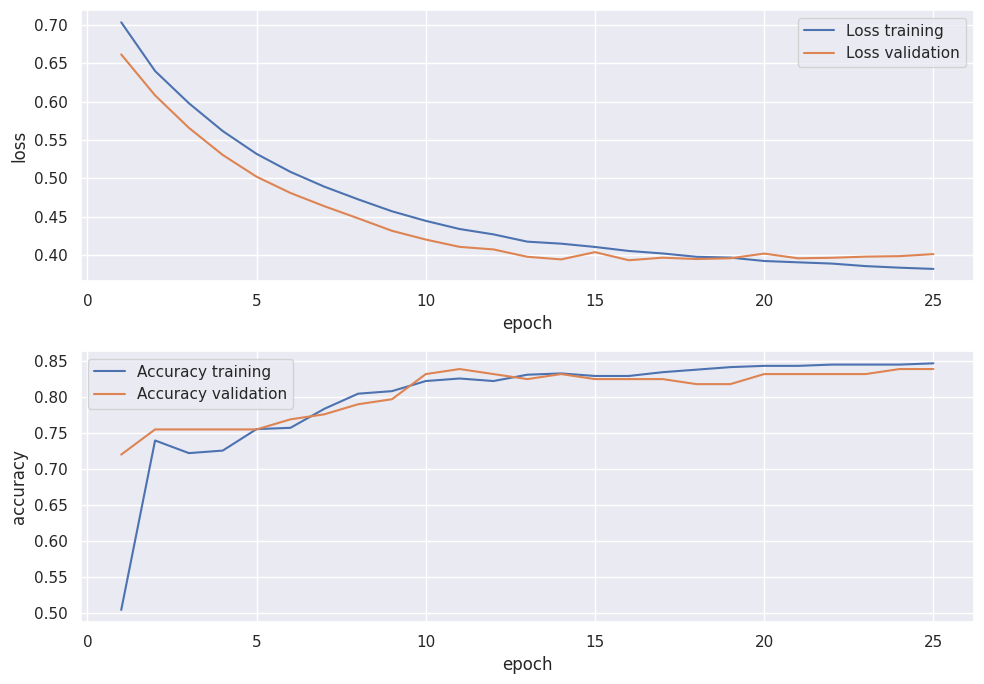

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

sns.lineplot(x=df_training_history.index, y=df_training_history['loss'], ax=axs[0], label='Loss training')

sns.lineplot(x=df_training_history.index, y=df_training_history['val_loss'], ax=axs[0], label='Loss validation')

sns.lineplot(x=df_training_history.index, y=df_training_history['accuracy'], ax=axs[1], label='Accuracy training')

sns.lineplot(x=df_training_history.index, y=df_training_history['val_accuracy'], ax=axs[1], label='Accuracy validation')

plt.tight_layout()

plt.show()

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
accuracy train: 0.848
accuracy test: 0.832


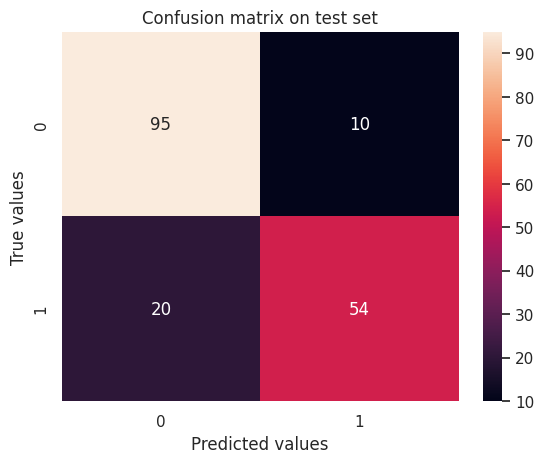

(0.848314606741573,
 0.8324022346368715,
 array([[95, 10],
        [20, 54]]))

In [ ]:
evaluate_model(model, X_train, y_train, X_test, y_test, show_confusion_matrix=True)